In [1]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc
from utils import log10eaxis, logjacob, makedist, makelogjacob, bkgdist, edisp, offsetaxis, fake_signal_position_dist, inverse_transform_sampling, psf, norme_vals_mesh, normoffset_vals_mesh, setup_full_fake_signal_dist, calcirfvals
from utils import psffull, evaluateintegral, evaluateformass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from scipy import special,stats
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
sys.path.append("BFCalc")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test and Setup

In [2]:
offsetvals = np.linspace(-3.5,3.5,8)
logevals = np.linspace(-1,2,31)
offsetvalsmesh, logevalsmesh = np.meshgrid(offsetaxis, log10eaxis)


colormap = cm.get_cmap('coolwarm')

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_17274/1171364216.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('coolwarm')


In [3]:
# edispmatrix = np.empty(shape=(log10eaxis.shape[0], log10eaxis.shape[0]))

# for ii, log10eval in notebook_tqdm(enumerate(log10eaxis), total=log10eaxis.shape[0]):
#     edispmatrix[ii,:] = edisp(log10eaxis, log10eval, 1.5)



In [4]:
# plt.figure()
# plt.pcolor(log10eaxis, log10eaxis, edispmatrix, vmin=np.max(edispmatrix)-5, vmax = np.max(edispmatrix))
# plt.colorbar()
# plt.show()

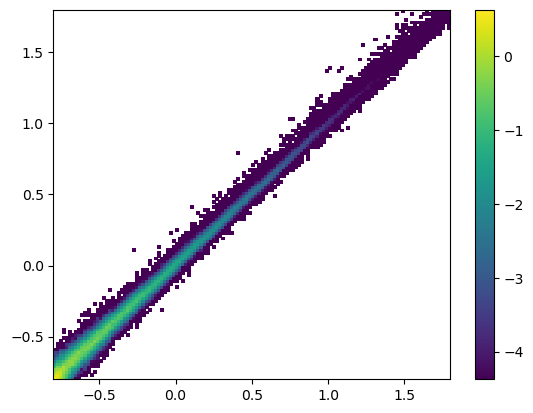

In [5]:
# psfmatrix = np.empty(shape=(offsetaxis.shape[0], offsetaxis.shape[0]))

# for ii, offsetval in notebook_tqdm(enumerate(offsetaxis), total=offsetaxis.shape[0]):
#     psfmatrix[ii,:] = psf(offsetaxis, offsetval, -0.9)

In [6]:
# plt.figure()
# plt.pcolor(offsetaxis, offsetaxis, psfmatrix)
# plt.show()

# Simulation

In [7]:
log10emesh, offsetmesh = np.meshgrid(log10eaxis, offsetaxis)
Nsamples=int(1e3)
truelambda = 0.5
nsig = int(round(truelambda*Nsamples))
nbkg = int(round((1-truelambda)*Nsamples))

truelogmassval = 1.0

In [8]:
sigpriorvalues = []

for ii, logeval in enumerate(log10eaxis):
    singlerow = setup_full_fake_signal_dist(truelogmassval, specsetup=DM_spectrum_setup, normeaxis=10**log10eaxis)(logeval, offsetaxis)
    sigpriorvalues.append(singlerow)
sigpriorvalues = np.array(sigpriorvalues)
sigpriorvalues.shape
    

/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor


(130, 351)

In [9]:
bkgpriorvalues = []

for ii, logeval in notebook_tqdm(enumerate(log10eaxis), total=log10eaxis.shape[0]):
    singlerow = []
    for ii, offsetval in enumerate(offsetaxis):
        singlerow.append(bkgdist(logeval, offsetval))
    bkgpriorvalues.append(singlerow)
bkgpriorvalues = np.squeeze(np.array(bkgpriorvalues))

100%|██████████| 130/130 [00:01<00:00, 81.22it/s]


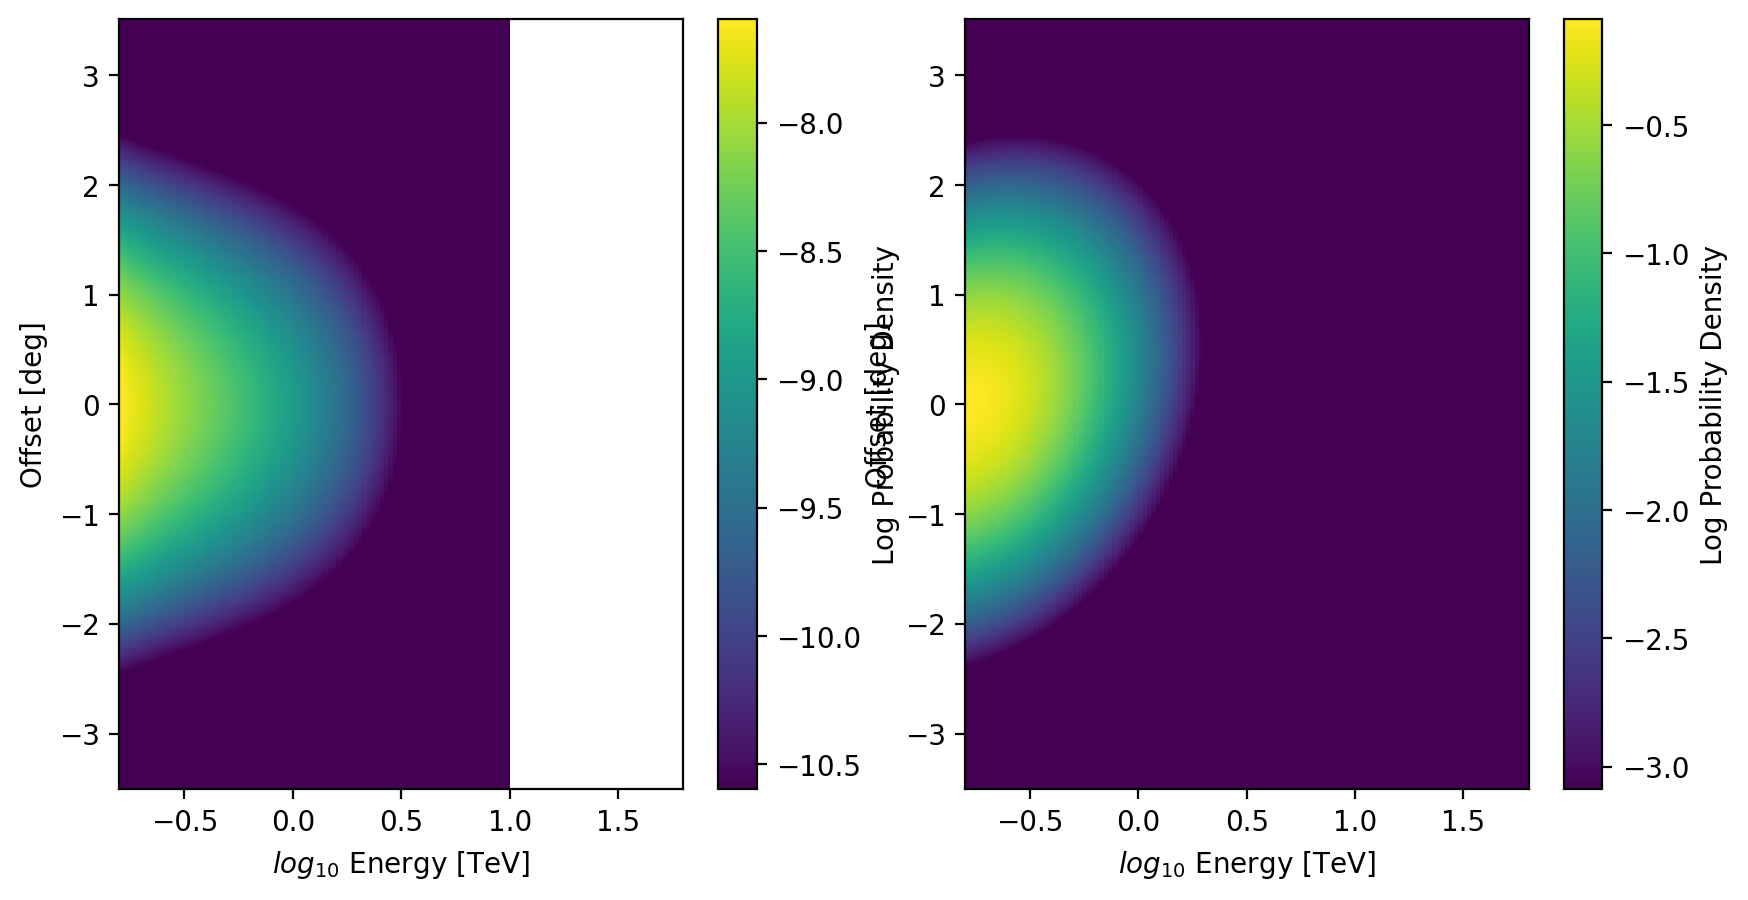

In [10]:
plt.figure(figsize=(10,5), dpi=200)
plt.subplot(1,2,1)
plt.pcolormesh(log10eaxis, offsetaxis, sigpriorvalues.T, vmin=np.max(sigpriorvalues)-3, vmax=np.max(sigpriorvalues))
plt.xlabel(r'$log_{10}$ Energy [TeV]')
plt.ylabel('Offset [deg]')
plt.colorbar(label='Log Probability Density')


plt.subplot(1,2,2)
plt.pcolormesh(log10eaxis, offsetaxis, bkgpriorvalues.T, vmin=np.max(bkgpriorvalues)-3, vmax=np.max(bkgpriorvalues))
plt.xlabel(r'$log_{10}$ Energy [TeV]')
plt.ylabel('Offset [deg]')
plt.colorbar(label='Log Probability Density')

In [11]:
sigbinnedprior = sigpriorvalues.T+logjacob
flattened_sigbinnedprior = sigbinnedprior.flatten()


bkgbinnedprior = bkgpriorvalues.T+logjacob
flattened_bkgbinnedprior = bkgbinnedprior.flatten()

## Checking prior normalisations

In [12]:
special.logsumexp(sigbinnedprior)

0.0

In [13]:
bkgnormalisation = special.logsumexp(bkgbinnedprior)

bkgbinnedprior = bkgbinnedprior - bkgnormalisation

bkgnormalisation

7.266114262390152

## Signal Simulation

In [14]:
sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_sigbinnedprior, Nsamples=nsig),sigbinnedprior.shape)
siglogevals = log10eaxis[sigresultindices[1]]
sigoffsetvals = offsetaxis[sigresultindices[0]]

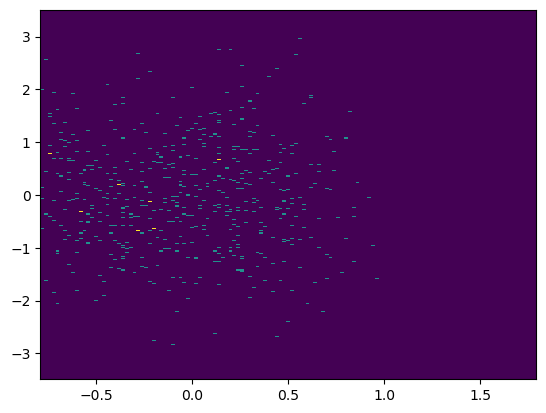

In [15]:
plt.figure()
plt.hist2d(siglogevals, sigoffsetvals, bins=[log10eaxis, offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0])])
# for val in offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0]):
#     plt.axhline(val, alpha=0.1, c='tab:orange')
plt.show()

In [16]:
signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, offsetval)+logjacob, Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=nsig)])]

  0%|          | 0/500 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
100%|██████████| 500/500 [00:34<00:00, 14.58it/s]


In [17]:
signal_offset_measured = offsetaxis[np.squeeze([inverse_transform_sampling(psf(offsetaxis, offsetval, logeval), Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=nsig)])]


  0%|          | 0/500 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:77: RuntimeWarning: divide by zero encountered in log
  psffunc = lambda offsetrecon: np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
100%|██████████| 500/500 [21:31<00:00,  2.58s/it]


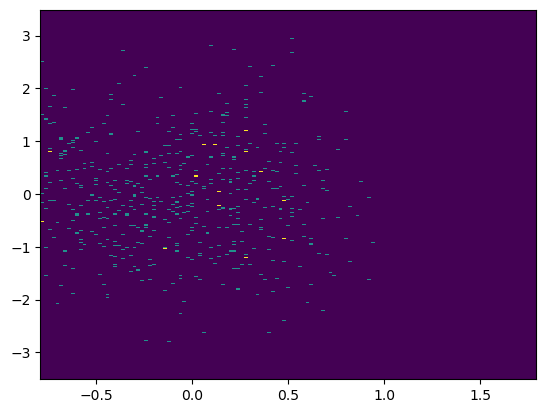

500.0

In [18]:
plt.figure()
histvals = plt.hist2d(signal_log10e_measured, signal_offset_measured, bins=[log10eaxis, offsetaxis-0.5*(offsetaxis[1]-offsetaxis[0])])
plt.show()

np.sum(histvals[0])

## Background Simulations

In [19]:
bkgresultindices = np.unravel_index(inverse_transform_sampling(flattened_bkgbinnedprior, Nsamples=nbkg),sigbinnedprior.shape)
bkglogevals = log10eaxis[bkgresultindices[1]]
bkgoffsetvals = offsetaxis[bkgresultindices[0]]

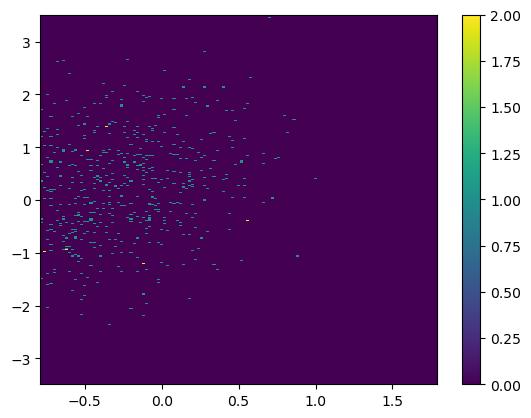

In [20]:
plt.figure()
plt.hist2d(bkglogevals, bkgoffsetvals, bins=[log10eaxis, offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0])])
plt.colorbar()
plt.show()

In [21]:
bkg_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, offsetval)+logjacob, Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(bkglogevals, bkgoffsetvals), total=nbkg)])]

100%|██████████| 500/500 [00:40<00:00, 12.38it/s]


In [22]:
bkg_offset_measured = offsetaxis[np.squeeze([inverse_transform_sampling(psf(offsetaxis, offsetval, logeval), Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(bkglogevals, bkgoffsetvals), total=nbkg)])]


100%|██████████| 500/500 [21:59<00:00,  2.64s/it]


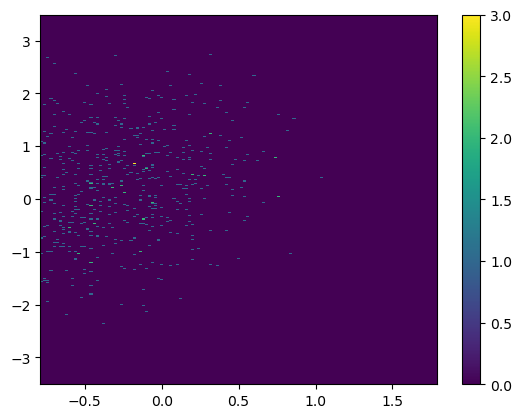

500.0

In [23]:
plt.figure()
histvals = plt.hist2d(bkg_log10e_measured, bkg_offset_measured, bins=[log10eaxis, offsetaxis-0.5*(offsetaxis[1]-offsetaxis[0])])
plt.colorbar()
plt.show()

np.sum(histvals[0])

# Nuisance Parameter Marginalisation

## Setup

Hello

In [45]:
sigdistsetup = setup_full_fake_signal_dist
# Makes it so that when np.log(0) is called a warning isn't raised as well as other errors stemming from this.
np.seterr(divide='ignore', invalid='ignore')


true_offset_vals             = np.array(list(sigoffsetvals)+list(bkgoffsetvals))
measured_offset_vals         = np.array(list(signal_offset_measured)+list(bkg_offset_measured))
true_log10e_vals             = np.array(list(siglogevals)+list(bkglogevals))
measured_log10e_vals         = np.array(list(signal_log10e_measured)+list(bkg_log10e_measured))

numcores                = 10


nbinslogmass            = 81
logmasswindowwidth      = 2/np.sqrt(nsig)

nbinslambda             = 101
lambdawindowwidth       = 10/np.sqrt(Nsamples)


logmasslowerbound       = truelogmassval-logmasswindowwidth
logmassupperbound       = truelogmassval+logmasswindowwidth


lambdalowerbound        = truelambda-lambdawindowwidth
lambdaupperbound        = truelambda+lambdawindowwidth


# if logmasslowerbound<log10eaxis[1]:
logmasslowerbound = log10eaxis[1]
# if logmassupperbound>2:
logmassupperbound = 2
        
        
# if lambdalowerbound<0:
lambdalowerbound = 0
# if lambdaupperbound>1:
lambdaupperbound = 1


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass)    
lambdarange             = np.linspace(lambdalowerbound, lambdaupperbound, nbinslambda)

## Calculating IRF probability densities

In [25]:

irfvals = []
with Pool(numcores) as pool: 
        for result in notebook_tqdm(pool.imap(calcirfvals, zip(measured_log10e_vals, measured_offset_vals)), 
                            total=len(list(measured_log10e_vals)), ncols=100, desc="Calculating irfvals"):
                irfvals.append(result)

        pool.close() 

Calculating irfvals:   0%|                                                 | 0/1000 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon

## Signal Marginalisations

In [26]:
produce_logsigmarg_function = functools.partial(evaluateformass, irfvals=irfvals, specsetup=DM_spectrum_setup)
signal_log_marginalisationvalues = []
with Pool(numcores) as pool: 
        
        for result in notebook_tqdm(pool.imap(produce_logsigmarg_function, logmassrange), total=len(list(logmassrange)), ncols=100, desc="Calculating signal marginalisations..."):
                signal_log_marginalisationvalues.append(result)

        pool.close() 
signal_log_marginalisationvalues = np.array(signal_log_marginalisationvalues)
signal_log_marginalisationvalues.shape

Calculating signal marginalisations...:   0%|                                | 0/81 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor
/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor
Calculating signal marginalisations...:   1%|▎                       | 1/81 [00:03<05:17,  3.97s/it]/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor
Calculating signal marginalisations...:   4%|▉                       | 3/81 [00:04<01:24,  1.09s/it]/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor
Calculating signal marginalisations...:   5%|█▏         

(81, 1000)

## Background Marginalisations

In [27]:
produce_logbkgmarg_function = functools.partial(evaluateintegral, priorvals=bkgpriorvalues.T-bkgnormalisation)

bkg_log_marginalisationvalues = []
with Pool(numcores) as pool: 
        for result in notebook_tqdm(pool.imap(produce_logbkgmarg_function, irfvals), total=len(list(irfvals)), ncols=100, desc="Calculating background marginalisations..."):
                bkg_log_marginalisationvalues.append(result)

        pool.close() 
bkg_log_marginalisationvalues = np.array(bkg_log_marginalisationvalues)
bkg_log_marginalisationvalues.shape

Calculating background marginalisations...: 100%|██████████████| 1000/1000 [00:03<00:00, 258.05it/s]


(1000,)

# Calculating hyperparameter posterior

In [46]:
logposterior = []

for ii, logmass in notebook_tqdm(enumerate(logmassrange), total=len(list(logmassrange))):
    singlerow = []
    for jj, lambdaval in enumerate(lambdarange):
        product = np.sum(np.logaddexp(np.log(lambdaval)+signal_log_marginalisationvalues[ii,:], np.log(1-lambdaval)+bkg_log_marginalisationvalues))
        singlerow.append(product)
    logposterior.append(singlerow)
logposterior = np.array(logposterior)

normalisedlogposterior = logposterior-special.logsumexp(logposterior)

100%|██████████| 81/81 [00:00<00:00, 241.61it/s]


# Analysing results

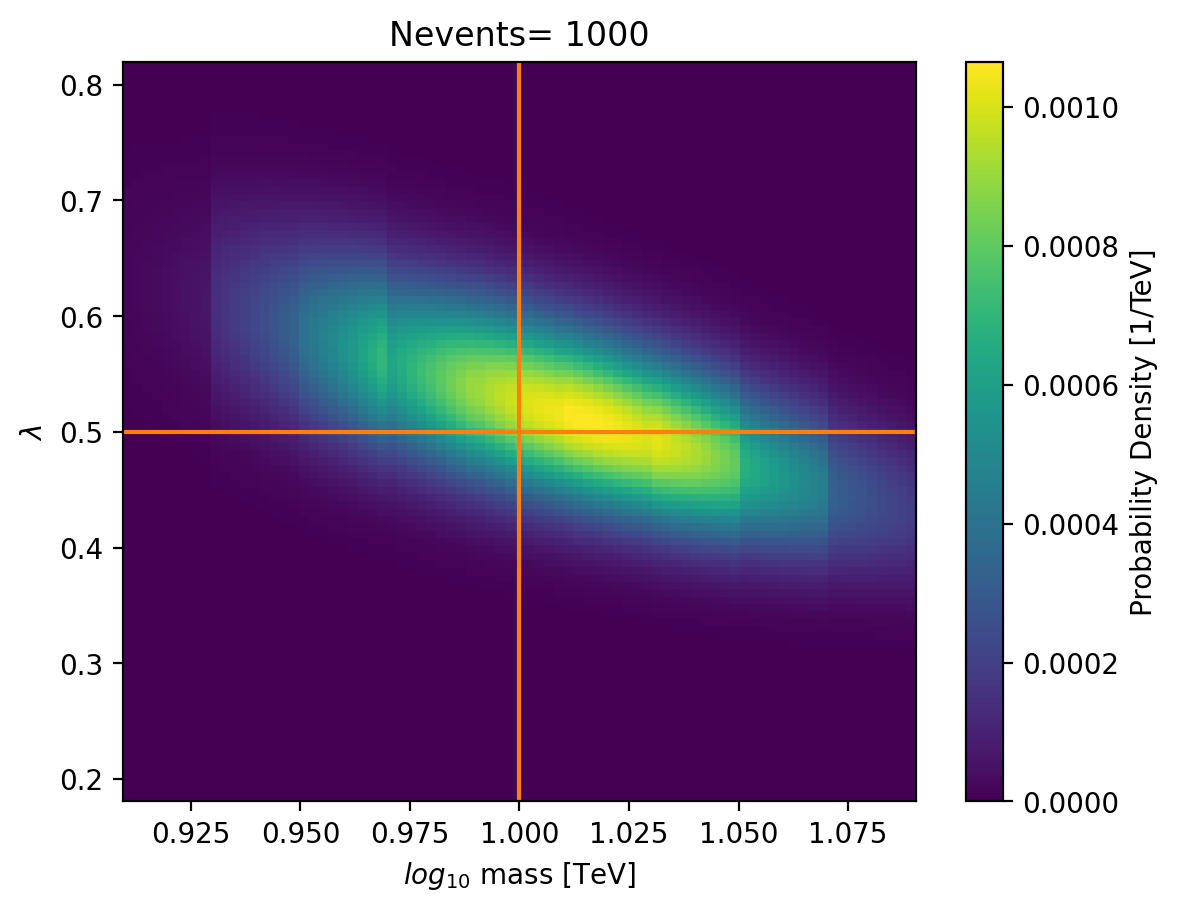

In [57]:
plt.figure(dpi=200)
plt.pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T)
plt.axvline(truelogmassval, c='tab:orange')
plt.axhline(truelambda, c='tab:orange')
plt.title(f"Nevents= {Nsamples}")
plt.xlabel(r'$log_{10}$ mass [TeV]')
plt.ylabel(r'$\lambda$')
plt.colorbar(label='Probability Density [1/TeV]')
plt.show()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_17274/285908450.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


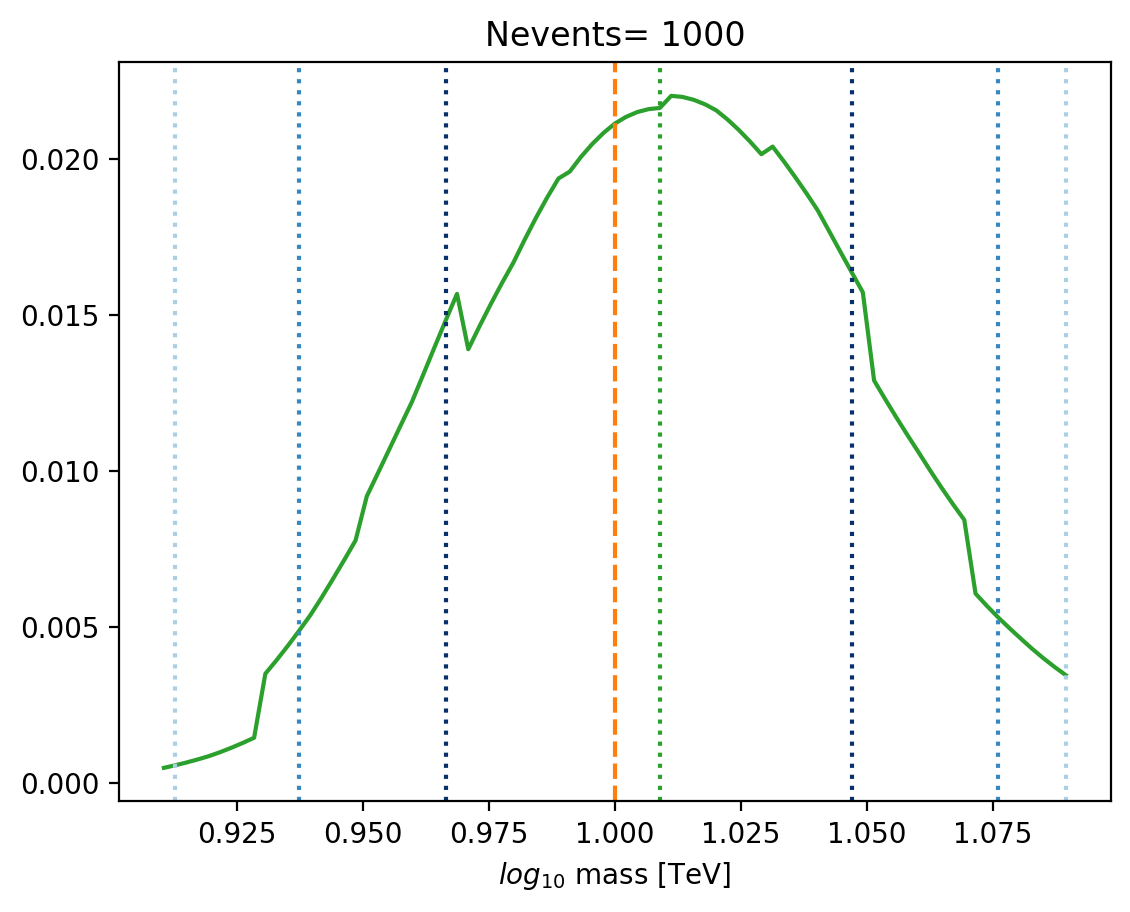

In [54]:
from scipy.stats import norm

colormap = cm.get_cmap('Blues_r', 4)

logmass_logposterior = special.logsumexp(normalisedlogposterior, axis=1)
logmass_logposterior.shape

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdfposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdfposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
percentiles = []
for zscore in zscores:
    percentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdfposterior).argmin()])

plt.figure(dpi=200)
plt.title(f"Nevents= {Nsamples}")
plt.plot(logmassrange,normalisedlogmassposterior, c='tab:green')

plt.axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(percentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            plt.axvline(percentile, c=color, ls=':')
plt.axvline(truelogmassval, ls='--', color="tab:orange")
plt.xlabel(r'$log_{10}$ mass [TeV]')
plt.show()

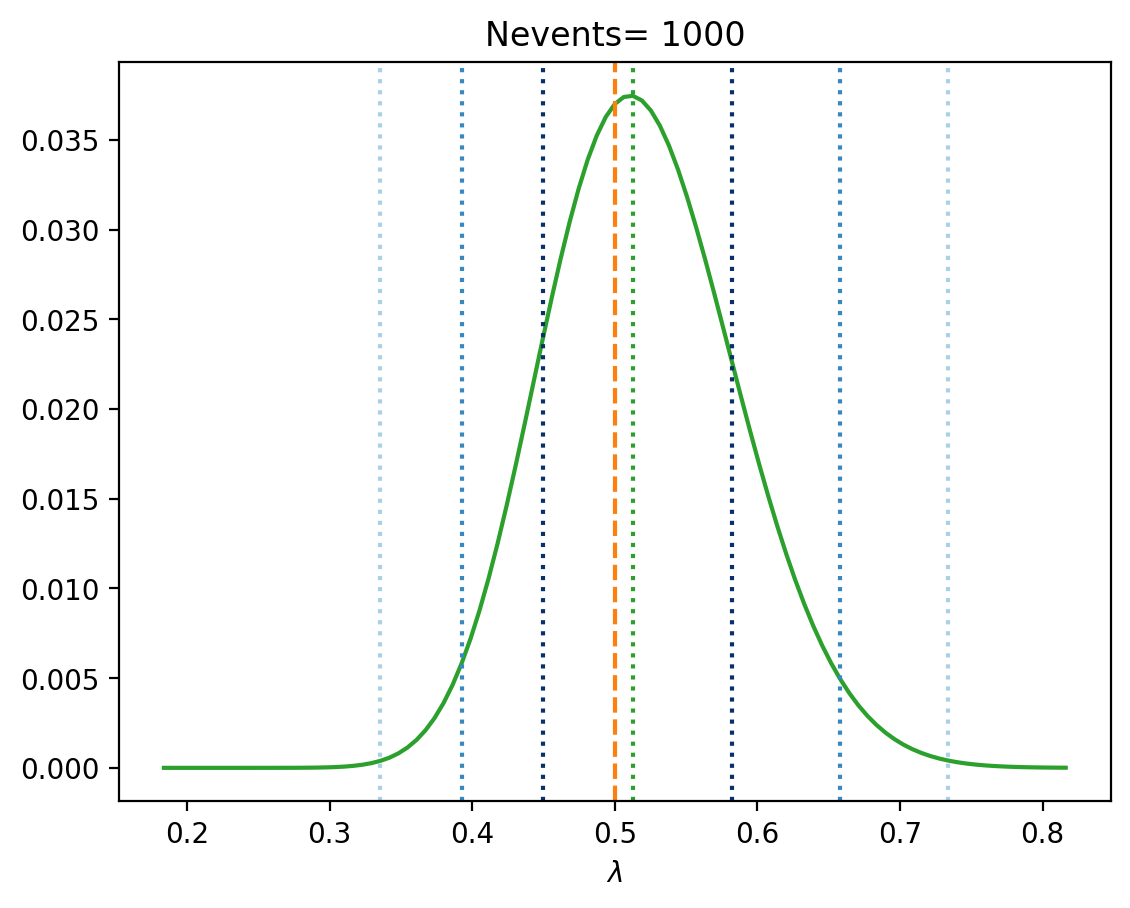

In [56]:
lambda_logposterior = special.logsumexp(normalisedlogposterior, axis=0)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlabda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentiles.append(lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()])

plt.figure(dpi=200)
plt.title(f"Nevents= {Nsamples}")
plt.plot(lambdarange,normalisedlambdaposterior, c='tab:green')

plt.axvline(meanlabda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            plt.axvline(percentile, c=color, ls=':')
plt.axvline(truelambda, ls='--', color="tab:orange")
plt.xlabel(r'$\lambda$')
plt.show()